<a href="https://www.kaggle.com/code/mcpenguin/smoking-drinking-prediction-tfdf-71?scriptVersionId=143235036" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

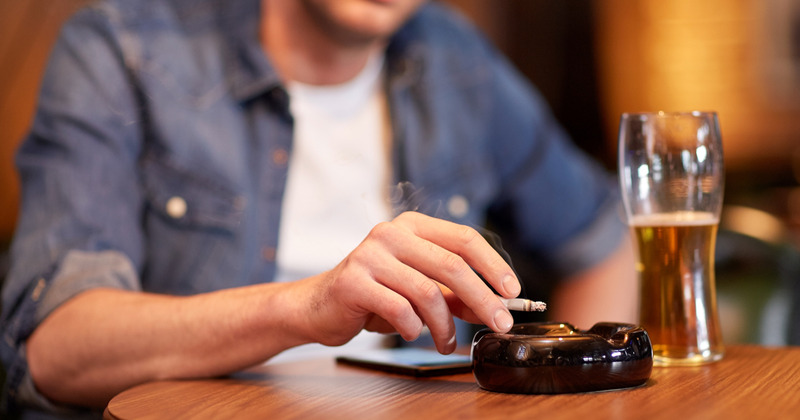

*Image source: Cancer Center*

# Smoking & Drinking Data - EDA and Classification

In this notebook, we investigate the Smoking and Drinking dataset. We will first take an initial look at the dataset and use domain knowledge to engineer features. Next, we will perform exploratory data analysis on the dataset. Then, due to the large size of the dataset, we will use Tensorflow's Decision Forests library to build and predict models to classify the individuals' smoking and drinking statuses. Finally, we will evaluate our model on the test set by using classification reports and confusion matrices.

--- 

If this was helpful or informative, I would appreciate it a lot if you left an upvote!

---

# Import Libraries

In [ ]:
import numpy as np # linear algebra
from scipy.stats import randint, uniform
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from itertools import product

from IPython.display import display, Markdown
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
import tensorflow_decision_forests as tfdf

In [ ]:
# suppress chained assignment warnings
pd.options.mode.chained_assignment = None
# random seed
np.random.seed(42)

tqdm.pandas()

def _display(text):
    display(Markdown(text))

In [ ]:
print(f"Is GPU available: {tf.test.is_gpu_available()}")

# Load + Investigate Data

In this section, we load the dataset and investigate the variates, including the original data source.

In [ ]:
df = pd.read_csv("/kaggle/input/smoking-drinking-dataset/smoking_driking_dataset_Ver01.csv")
df.head()

## Only Consider Subset of Data for Time Reasons

As our dataset has nearly 1M rows, running our code will include a lot of waiting if we use the full dataset, especially in the EDA and modelling section.

As such, to save time and resources, we can just consider a subsample of the full dataset for our analysis and prediction.

In [ ]:
# comment this line for full analysis
# df = df.sample(5000)

## Investigating Data Source & Column Descriptions

As the column descriptions in the dataset prompt are only surface level and do not delve into the details of the columns, it would be a good idea to further investigate the meaning behind some of these columns, especially the more scientific ones. This will allow us to better understand our data, as well as perhaps reveal potential features we could engineer before modelling.

### Method

To do this, I looked at the [dataset's source](https://www.data.go.kr/data/15007122/fileData.do), which you can find from the **Provenance** section in the dataset. Using Google Translate to help translate the website content (because I cannot speak/read Korean), I was able to find the [column descriptions](https://www.data.go.kr/data/15007122/fileData.do#layer_data_infomation) for this dataset, which was in a `.hwp` file format. Using an online converter, I was able to convert this into a PDF. Again, using Google Translate, I was able to decipher the data information on this PDF.

### More Detailed Feature Table

I will provide the details of the column explanations here, collated with the data descriptions from the dataset description and the original data source, alongside supplementary information referenced from external sources for the more technical variates.

*Note 1: 1 dL, or 1 deci-litre, is equivalent to 100 mL (millilitres) or 0.1 L (litres).*

*Note 2: IUs, or international units, are units of measurement used to quantify the effect/biological activity of a substance. [source](https://en.wikipedia.org/wiki/International_unit)*

* `sex` represents the sex of the individual - male or female.

* In the original study, `age` was categorized into 5-year intervals; i.e. 20-24 years, 25-29 years, ..., 85+ years. These intervals were then converted into numeric values by taking the lower bound of the interval. (e.g. 20-24 years -> 20 years)

* `height` represents the height of the individual, in 5cm increments.

* `weight` represents the weight of the individual, in 5kg increments.

* `waist` represents the circumference of the individual's waist.

* `sight_left` represents the visual acuity of the individual's left eye. *Visual acuity* measures the ability of the eye to distinguish shapes and object details at a given distance. This ranges from 0.1-2.5, with values <0.1 being shifted up to 0.1. [source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4069781/#:~:text=Visual%20acuity%20(VA)%20is%20a,detect%20any%20changes%20in%20vision.) 

* `sight_right` represents the visual acuity of the individual's right eye.

* `hear_left` measures the hearing in the left ear of the individual, with 1 representing it being normal and 2 representing it being abnormal.

* `hear_right` measures the hearing in the right ear of the individual with the same classification system as `hear_left`.

* `SBP` measures the highest systolic blood pressure measured from the individual, in mmHg. *Systolic blood pressure* measures the pressure in the arteries when the heart beats. [source](https://www.cdc.gov/bloodpressure/about.htm#:~:text=Blood%20pressure%20is%20measured%20using,your%20heart%20rests%20between%20beats.)

* `DBP` measures the diastolic blood pressure measured from the individual, in mmHg. *Diastolic blood pressure* measures the pressure in the arteries when the heart rests between beats. (Same source as above.)

* `BLDS` measures the individual's fasting blood glucose, in mg/dL. This represents the concentration of glucose per 100ml of blood prior to eating a meal.

* `tot_chole` measures the total concentration of (ester and non-ester) cholestorol in the individual, in mg/dL.

* `HDL_chole` measures the total concentration of cholestorol in the individual's HDL (high density lipoprotein) region, in mg/dL. *HDL cholestorol*, also called *good cholestorol*, absorbs cholestorol in the blood and carries it back to the liver, which then flushes it from the body. Note that higher values of HDL cholestorol can lower risk of heart disease. [source](https://www.cdc.gov/cholesterol/ldl_hdl.htm#:~:text=HDL%20(high%2Ddensity%20lipoprotein),for%20heart%20disease%20and%20stroke.)

* `LDL_chole` measures the total concentration of cholestorol in the LDL (low density lipoprotein) region, in mg/dL. *LDL cholestorol*, also called *bad cholestorol*, makes up most of the body's cholestorol. High levels of this can raise risk of heart disease and stroke. [source](https://www.cdc.gov/cholesterol/ldl_hdl.htm#:~:text=Two%20types%20of%20lipoproteins%20carry,for%20heart%20disease%20and%20stroke.)

* `triglyceride` measures the total concentration of triglyceride in the individual's blood, in mg/dL. *Triglycerides* are a type of lipids (i.e. fat) that circulate in our blood, and usually originate from foods we consume. [source](https://www.nhlbi.nih.gov/health/high-blood-triglycerides#:~:text=Triglycerides%20are%20a%20type%20of,does%20not%20need%20right%20away.)

* `hemoglobin` measures the total concentration of hemoglobin in the individual's blood, in g/dL. `Hemoglobin` is a protein in our red blood cells that carries oxygen. [source](https://www.mountsinai.org/health-library/tests/hemoglobin#:~:text=Hemoglobin%20is%20a%20protein%20in,is%20exchanged%20for%20carbon%20dioxide.)

* `urine_protein` measures the amount of protein in the individual's urine. High levels of protein in urine, or *proteinuria*, can be a sign of many health problems, like heart failure and kidney problems. [source](https://www.mountsinai.org/health-library/tests/protein-urine-test). It is unclear what the label encodings (1(-), 2(+/-), 3(+1), 4(+2), 5(+3), 6(+4)) for this variate means, although we could speculate it refers to the amount of standard deviations from the mean the value resides at in the feature distribution.

* `serum_creatine` measures the concentration of creatinine in the individual's serum (which resides in their blood), in mg/dL. *Creatinine* is a waste product of creatine, which is produced to supply energy mainly to the muscles. Usually, this is removed by your kidneys entirely; thus, if kidney function is abnormal, the concentration of creatinine will increase. [source](https://www.mountsinai.org/health-library/tests/creatinine-blood-test#:~:text=Creatinine%20is%20a%20chemical%20waste,body%20entirely%20by%20the%20kidneys.). Normal values are around 0.8-2.7 mg/dL.

* `SGOT_AST` measures the SGOT (Glutamate-oxaloacetate transaminase) - AST (Aspartate transaminase) value in IU/L, which are values in blood tests that quantify liver, heart and other organs' performance. In particular, when these are damaged, the value of this goes up. Normal values are around 0-40 IU/L.

* `SGOT_ALT` measures the SGOT (Glutamate-oxaloacetate transaminase) - ALT (Alanine transaminase) value in IU/L, which are values in blood tests that quantify liver performance. In particular, when this are damaged, the value of this goes up. Normal values are around 0-40 IU/L.

* `gamma_GTP` measures the gamma-GTP (y-glutamyl transpeptidase) value in IU/L, which are values that quantify liver function in the bile dict. Normal values of this are around 11-63 IU/L for men, and 8-35 IU/L for women.

* `SMK_STAT_TYPE_CD` measures the individual's smoking state, where 1 corresponds to them never smoking, 2 corresponds to them having used to smoke but quit, and 3 corresponds to them still smoking.

* `DRK_YN` is a flag that indicates whether the individual is a drinker or not.

## Initial Description of Data

In [ ]:
df.info()

We see that the dataset is very large and that there are no missing values. Overall, this data looks very clean!

In [ ]:
df.describe()

## Feature Engineering

Before moving on to EDA, we might want to engineer some features from our analysis of the dataset columns.

### Adding Ratios/Combinations of Features

One way to combine features in the dataset is to introduce ratios, or combinations of features.

We introduce some helper functions to help us compute these ratios or formulas:

In [ ]:
def get_bmi(row):
    weight = row["weight"]
    height = row["height"]
    return weight / (height ** 2)

def get_blood_pressure_ratio(row):
    sbp = row["SBP"]
    dbp = row["DBP"]
    return sbp / dbp

def get_hdl_cholestorol_ratio(row):
    hdl_chole = row["HDL_chole"]
    total_chole = row["tot_chole"]
    return hdl_chole / total_chole

def get_ldl_cholestorol_ratio(row):
    ldl_chole = row["LDL_chole"]
    total_chole = row["tot_chole"]
    return ldl_chole / total_chole

We can then add them to our dataset.

In [ ]:
df["bmi"] = df.progress_apply(get_bmi, axis=1)
df["BP_ratio"] = df.progress_apply(get_blood_pressure_ratio, axis=1)
df["HDL_ratio"] = df.progress_apply(get_hdl_cholestorol_ratio, axis=1)
df["LDL_ratio"] = df.progress_apply(get_ldl_cholestorol_ratio, axis=1)

### Adding "Normal" Encodings for Features

Many of the column descriptions we acquired from the original source lists "normal" ranges of many of the numeric variates. Thus, a natural feature we can add to our data would be flags indicating whether the values of the data fall in these normal ranges.

In [ ]:
def classify_eyesight(val):
    if val > 1: # > 20/20 eyesight
        return "Good"
    elif val > 0.5: # > 20/40 eyesight
        return "Average"
    elif val > 0.25: # > 20/80 eyesight
        return "Poor"
    else:
        return "Very Poor"

# https://my.clevelandclinic.org/health/diseases/17649-blood-pressure
def classify_blood_pressure(row):
    sbp = row["SBP"]
    dbp = row["DBP"]
    if sbp < 120 and dbp < 80:
        return "Normal"
    elif sbp < 130 and dbp < 80:
        return "Elevated"
    elif sbp < 140 and dbp < 90:
        return "Hypertension Stage 1"
    elif sbp < 180 and dbp < 120:
        return "Hypertension Stage 2"
    else:
        return "Hypertensive Crisis"
    
# https://www.who.int/data/gho/indicator-metadata-registry/imr-details/2380
def classify_blood_glucose(row):
    blood_glucose = row["BLDS"]
    if blood_glucose < 100:
        return "Normal"
    elif blood_glucose < 125:
        return "Pre-Diabetes"
    else:
        return "Diabetes"
    
def classify_serum_creatinine(row):
    serum_creatinine = row["serum_creatinine"]
    if serum_creatinine < 2.7:
        return "Normal"
    else:
        return "Abnormal"
    
def classify_SGOT_AST(row):
    sgot_ast = row["SGOT_AST"]
    if sgot_ast < 40:
        return "Normal"
    else:
        return "Abnormal"
    
def classify_SGOT_ALT(row):
    sgot_alt = row["SGOT_ALT"]
    if sgot_alt < 40:
        return "Normal"
    else:
        return "Abnormal"
    
def classify_gamma_GTP(row):
    gamma_gtp = row["gamma_GTP"]
    sex = row["sex"]
    if sex == "Male":
        if gamma_gtp >= 11 and gamma_gtp <= 63:
            return "Normal"
        else:
            return "Abnormal"
    else:
        if gamma_gtp >= 8 and gamma_gtp <= 35:
            return "Normal"
        else:
            return "Abnormal"

We can then apply these classifications to the dataset.

In [ ]:
df["sight_left_class"] = df["sight_left"].progress_apply(classify_eyesight)
df["sight_right_class"] = df["sight_right"].progress_apply(classify_eyesight)

df["blood_pressure_class"] = df.progress_apply(classify_blood_pressure, axis=1)
df["blood_glucose_class"] = df.progress_apply(classify_blood_glucose, axis=1)
df["serum_creatinine_class"] = df.progress_apply(classify_serum_creatinine, axis=1)
df["SGOT_AST_class"] = df.progress_apply(classify_SGOT_AST, axis=1)
df["SGOT_ALT_class"] = df.progress_apply(classify_SGOT_ALT, axis=1)
df["gamma_GTP_class"] = df.progress_apply(classify_gamma_GTP, axis=1)

### Rename Response Variates

To make the response variables more descriptive, we will rename the values.

In [ ]:
response_feature_drinking = 'DRK_YN'
response_feature_smoking = 'SMK_stat_type_cd'

smoking_values_dict = {
    1: 'Never Smoked',
    2: 'Smoked But Quit',
    3: 'Is Smoking'
}

for k, v in smoking_values_dict.items():
    df.loc[df[response_feature_smoking] == k, response_feature_smoking] = v
    
drinking_values_dict = {
    "Y": 'Drinker',
    "N": "Non-Drinker"
}

for k, v in drinking_values_dict.items():
    df.loc[df[response_feature_drinking] == k, response_feature_drinking] = v

# Exploratory Data Analysis

Let's perform some exploratory data analysis on the data.

Note processing these plots on the full dataset may take a long time, given that we have **almost 1 million records** in our dataframe. 

For reference, we list all the columns in our dataframe here:

In [ ]:
df.columns

## Separate Categorical/Numeric + Explanatory/Response Features

For our EDA and future steps, we will want to explicitly list the categorical and numeric features, as well as the explanatory and response features.

In [ ]:
# note: these are all binary
categorical_features = ['hear_left', 'hear_right', 
                        'sex', 'urine_protein', 'DRK_YN', 'SMK_stat_type_cd',
                       'sight_left_class', 'sight_right_class',
                       'blood_pressure_class', 'blood_glucose_class', 'serum_creatinine_class',
                       'SGOT_AST_class', 'SGOT_ALT_class', 'gamma_GTP_class']
numeric_features = ['age', 'height', 'weight', 'waistline', 'sight_left',
       'sight_right', 'SBP', 'DBP', 'BLDS',
       'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin',
       'serum_creatinine', 'SGOT_AST', 'SGOT_ALT',
       'gamma_GTP', 'BP_ratio', 'HDL_ratio', 'LDL_ratio', 'bmi']

explanatory_features = set(categorical_features + numeric_features).difference(set([response_feature_drinking, response_feature_smoking]))

## Histograms of Numeric Features

We can investigate the distributions of our numeric features by plotting histograms. In our plotting code, we also embed a progress bar using the `tqdm` library so we can keep track of our progress.

In [ ]:
fig, axes = plt.subplots(nrows=(len(numeric_features)+1) // 2, ncols=2, figsize=(20, 60))
plt.subplots_adjust(hspace=0.5)

pbar = tqdm(list(zip(axes.flat, numeric_features)))
for ax, col in pbar:
    pbar.set_postfix(col=col)
    if col in ["age", "height", "weight"]:
        binwidth = 5
    else:
        binwidth = None
    sns.histplot(data=df, x=col, ax=ax, bins=30, binwidth=binwidth)
    ax.set_title(f"Distribution of {col}")

plt.show()

## Countplots of Categorical Features

We can similar plot countplots of categorical features to investigate their distributions.

In [ ]:
fig, axes = plt.subplots(nrows=(len(categorical_features)+1) // 2, ncols=2, figsize=(12, 30))
plt.subplots_adjust(hspace=1)

pbar = tqdm(list(zip(axes.flat, categorical_features)))
for ax, col in pbar:
    pbar.set_postfix(col=col)
    sns.countplot(data=df, x=col, ax=ax)
    ax.set_title(f"Distribution of {col}")
    if col in ["urine_protein", "sight_left_class", "sight_right_class",
              "blood_pressure_class"]:
        ax.set_yscale('log')
    if col in ["blood_pressure_class"]:
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.show()

## Correlation Matrix of Numeric Features

We can also investigate the correlation matrix of numeric features in our dataset.

In [ ]:
plt.figure(figsize=(25, 25))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

# Preprocessing

Prior to modelling and training, we need to preprocess our data.

## Convert Categories into Indices

For training purposes, we need to label-encode our response variates.

In [ ]:
# convert response variates to indices
smoking_classes = list(smoking_values_dict.values())
drinking_classes = list(drinking_values_dict.values())

df[response_feature_smoking] = df[response_feature_smoking].map(smoking_classes.index)
df[response_feature_drinking] = df[response_feature_drinking].map(drinking_classes.index)

## Train/Validation/Test Split

We will split our dataset into a training, validation and test set.



In [ ]:
# due to the large size of the dataset, we only train on 5% of the data
# and test on the other 95%
# otherwise training takes too long

df_train, df_test = train_test_split(df, train_size=0.05)
df_train, df_val = train_test_split(df_train, train_size=0.8)

## Convert DFs into TF Datasets

We will then need to convert our dataframes into Tensorflow datasets, in order for us to use them in our models.

In [ ]:
# make datasets
train_ds_smoking = tfdf.keras.pd_dataframe_to_tf_dataset(df_train, label=response_feature_smoking)
val_ds_smoking = tfdf.keras.pd_dataframe_to_tf_dataset(df_val, label=response_feature_smoking)

train_ds_drinking = tfdf.keras.pd_dataframe_to_tf_dataset(df_train, label=response_feature_drinking)
val_ds_drinking = tfdf.keras.pd_dataframe_to_tf_dataset(df_val, label=response_feature_drinking)

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(df_test)

# Modelling

We are now ready to define our models to predict the smoking and drinking status of the individuals.

We first define a hyperparameter tuner:

In [ ]:
# don't use a lot of trials, since we have so much data
tuner = tfdf.tuner.RandomSearch(num_trials=3, use_predefined_hps=True)

We can then define our models:

In [ ]:
model_smoking = tfdf.keras.GradientBoostedTreesModel(tuner=tuner)
model_smoking.compile(metrics=["accuracy"])

model_drinking = tfdf.keras.GradientBoostedTreesModel(tuner=tuner)
model_drinking.compile(metrics=["accuracy"])

# Training

We can now fit our models to the training dataset.

In [ ]:
history_smoking = model_smoking.fit(train_ds_smoking, verbose=1)

In [ ]:
history_drinking = model_drinking.fit(train_ds_drinking, verbose=1)

## Best Hyperparameters

We can display the best hyperparameters for our models.

In [ ]:
tuning_logs_smoking = model_smoking.make_inspector().tuning_logs()
display(tuning_logs_smoking[tuning_logs_smoking.best].iloc[0])

In [ ]:
tuning_logs_drinking = model_drinking.make_inspector().tuning_logs()
display(tuning_logs_drinking[tuning_logs_drinking.best].iloc[0])

# Validation Loss

We can evaluate our models on the validation dataset.

In [ ]:
# Run evaluation for model_smoking
print("Evaluating smoking model:")
evaluation_smoking = model_smoking.evaluate(x=val_ds_smoking,return_dict=True)
for name, value in evaluation_smoking.items():
    print(f"{name}: {value:.4f}")

# Run evaluation for model_drinking
print("Evaluating drinking model:")
evaluation_drinking = model_drinking.evaluate(x=val_ds_drinking,return_dict=True)
for name, value in evaluation_drinking.items():
    print(f"{name}: {value:.4f}")

# Feature Importance

We can also visualize the relative importance of features in both models.

In [ ]:
inspector_smoking = model_smoking.make_inspector()
feature_importances_smoking = inspector_smoking.variable_importances()["NUM_NODES"]
feature_importances_smoking_df = pd.DataFrame.from_records(feature_importances_smoking, columns=["column", "score"])
feature_importances_smoking_df["column"] = feature_importances_smoking_df["column"].apply(lambda a: a[0])

inspector_drinking = model_drinking.make_inspector()
feature_importances_drinking = inspector_drinking.variable_importances()["NUM_NODES"]
feature_importances_drinking_df = pd.DataFrame.from_records(feature_importances_drinking, columns=["column", "score"])
feature_importances_drinking_df["column"] = feature_importances_drinking_df["column"].apply(lambda a: a[0])

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(25, 9))
fig.subplots_adjust(hspace=2)

sns.barplot(data=feature_importances_smoking_df, x="column", y="score", ax=axes[0])
axes[0].set_title("Feature importances for smoking")
for tick in axes[0].get_xticklabels():
    tick.set_rotation(90)

sns.barplot(data=feature_importances_drinking_df, x="column", y="score", ax=axes[1])
axes[1].set_title("Feature importances for drinking")
for tick in axes[1].get_xticklabels():
    tick.set_rotation(90)

plt.show()

# Predicting Test Dataset

We can now use our models to predict the values in the test dataset.

In [ ]:
df_test["pred_" + response_feature_smoking] = model_smoking.predict(test_ds).argmax(axis=1)
df_test["pred_" + response_feature_drinking] = (model_drinking.predict(test_ds) > 0.5) * 1

We can convert the label encoded response variates back to their original form:

In [ ]:
df_test[response_feature_smoking] = df_test[response_feature_smoking].apply(lambda x: smoking_classes[x])
df_test["pred_" + response_feature_smoking] = df_test["pred_" + response_feature_smoking].apply(lambda x: smoking_classes[x])

df_test[response_feature_drinking] = df_test[response_feature_drinking].apply(lambda x: drinking_classes[x])
df_test["pred_" + response_feature_drinking] = df_test["pred_" + response_feature_drinking].apply(lambda x: drinking_classes[x])

## Classification Report

We can see how well the model predicted the test set using a classification report:

### Smoking

In [ ]:
print(classification_report(df_test[response_feature_smoking], df_test["pred_" + response_feature_smoking], labels=smoking_classes))

### Drinking

In [ ]:
print(classification_report(df_test[response_feature_drinking], df_test["pred_" + response_feature_drinking], labels=drinking_classes))

## Confusion Matrix

We can also plot the confusion matrix for both models.

### Smoking

In [ ]:
plt.figure(figsize=(10, 10))

conf_matrix = confusion_matrix(df_test[response_feature_smoking], df_test["pred_" + response_feature_smoking])
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=smoking_classes)
disp.plot()

plt.show()

### Drinking

In [ ]:
plt.figure(figsize=(10, 10))

conf_matrix = confusion_matrix(df_test[response_feature_drinking], df_test["pred_" + response_feature_drinking])
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=drinking_classes)
disp.plot()

plt.show()

# Thank you for reading!